# MNIST digits classification with TensorFlow

<img src="images/mnist_sample.png" style="width:30%">

In [13]:
import numpy as np
import time
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
print("We're using TF", tf.__version__)

import sys
sys.path.append("../..")
import grading

import matplotlib_utils
from importlib import reload
reload(matplotlib_utils)

import grading_utils
reload(grading_utils)

import keras_utils
from keras_utils import reset_tf_session

We're using TF 1.2.1


# Fill in your Coursera token and email
To successfully submit your answers to our grader, please fill in your Coursera submission token and email

In [3]:
grader = grading.Grader(assignment_key="XtD7ho3TEeiHQBLWejjYAA", 
                        all_parts=["9XaAS", "vmogZ", "RMv95", "i8bgs", "rE763"])

In [4]:
# token expires every 30 min
COURSERA_TOKEN = "u2bQdurl8iEMdZ1J"
COURSERA_EMAIL = "emanuelfontelles@fisica.ufc.br"

# Look at the data

In this task we have 50000 28x28 images of digits from 0 to 9.
We will train a classifier on this data.

In [5]:
import preprocessed_mnist
X_train, y_train, X_val, y_val, X_test, y_test = preprocessed_mnist.load_dataset()

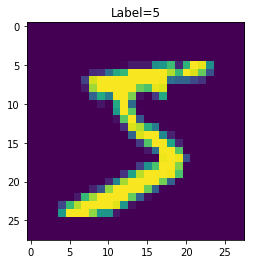

In [6]:
plt.imshow(X_train[0])
plt.title("Label="+str(y_train[0]));

In [7]:
# X contains rgb values divided by 255
print("X_train [shape %s] sample patch:\n" % (str(X_train.shape)), X_train[1, 15:20, 5:10])
print("A closeup of a sample patch:")

X_train [shape (50000, 28, 28)] sample patch:
 [[ 0.          0.29803922  0.96470588  0.98823529  0.43921569]
 [ 0.          0.33333333  0.98823529  0.90196078  0.09803922]
 [ 0.          0.33333333  0.98823529  0.8745098   0.        ]
 [ 0.          0.33333333  0.98823529  0.56862745  0.        ]
 [ 0.          0.3372549   0.99215686  0.88235294  0.        ]]
A closeup of a sample patch:


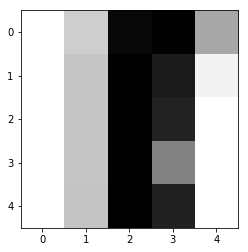

And the whole sample:


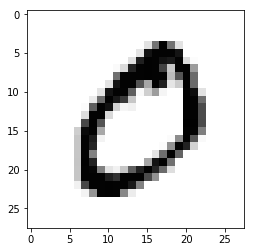

y_train [shape (50000,)] 10 samples:
 [5 0 4 1 9 2 1 3 1 4]


In [8]:
plt.imshow(X_train[1, 15:20, 5:10], cmap="Greys")
plt.show()
print("And the whole sample:")
plt.imshow(X_train[1], cmap="Greys")
plt.show()
print("y_train [shape %s] 10 samples:\n" % (str(y_train.shape)), y_train[:10])

# Linear model

Your task is to train a linear classifier $\vec{x} \rightarrow y$ with SGD using TensorFlow.

You will need to calculate a logit (a linear transformation) $z_k$ for each class: 
$$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$

And transform logits $z_k$ to valid probabilities $p_k$ with softmax: 
$$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

We will use a cross-entropy loss to train our multi-class classifier:
$$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$ 

where 
$$
[x]=\begin{cases}
       1, \quad \text{if $x$ is true} \\
       0, \quad \text{otherwise}
    \end{cases}
$$

Cross-entropy minimization pushes $p_k$ close to 1 when $y = k$, which is what we want.

Here's the plan:
* Flatten the images (28x28 -> 784) with `X_train.reshape((X_train.shape[0], -1))` to simplify our linear model implementation
* Use a matrix placeholder for flattened `X_train`
* Convert `y_train` to one-hot encoded vectors that are needed for cross-entropy
* Use a shared variable `W` for all weights (a column $\vec{w_k}$ per class) and `b` for all biases.
* Aim for ~0.93 validation accuracy

In [9]:
X_train_flat = X_train.reshape((X_train.shape[0], -1))
print(X_train_flat.shape)

X_val_flat = X_val.reshape((X_val.shape[0], -1))
print(X_val_flat.shape)

(50000, 784)
(10000, 784)


In [10]:
import keras

y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:3], y_train[:3])

(50000, 10)
[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]] [5 0 4]


In [ ]:
# run this again if you remake your graph
s = reset_tf_session()

# Model parameters: W and b 
W = tf.get_variable("W", shape=(784, 10), dtype=tf.float32, trainable=True) ### tf.get_variable(...) with shape[0] = 784
b = tf.get_variable("b", shape=(10,), dtype=tf.float32) ### tf.get_variable(...)

# Placeholders for the input data
input_X = tf.placeholder(tf.float32, shape=(None, 784))
input_y = tf.placeholder(tf.float32, shape=(None, 10))

# Compute predictions
logits = ### YOUR CODE HERE ### logits for input_X, resulting shape should be [input_X.shape[0], 10]
probas = ### YOUR CODE HERE ### apply tf.nn.softmax to logits
classes = ### YOUR CODE HERE ### apply tf.argmax to find a class index with highest probability

# Loss should be a scalar number: average loss over all the objects with tf.reduce_mean().
# Use tf.nn.softmax_cross_entropy_with_logits on top of one-hot encoded input_y and logits.
# It is identical to calculating cross-entropy on top of probas, but is more numerically friendly (read the docs).
loss = ### YOUR CODE HERE ### cross-entropy loss

# Use a default tf.train.AdamOptimizer to get an SGD step
step = ### YOUR CODE HERE ### optimizer step that minimizes the loss

In [11]:
hidden_1_size = 100
hidden_2_size = 50
g = tf.Graph()
with g.as_default():
    input_x = tf.placeholder(tf.float32,shape= [None,28,28])
    input_y = tf.placeholder(tf.int32,shape=[None,])
    
    x = tf.reshape(input_x,[-1,28*28])
    y = tf.one_hot(input_y,depth=10,axis=-1)
    
    w1 = tf.Variable(tf.truncated_normal([28*28,hidden_1_size],stddev=0.1),name='weight_1')
    b1 = tf.Variable(tf.zeros([hidden_1_size]),name='bias_1')
    w2 = tf.Variable(tf.truncated_normal([hidden_1_size,hidden_2_size],stddev=0.1),name='weight_2')
    b2 = tf.Variable(tf.zeros([hidden_2_size]),name='bias_1')
    w3 = tf.Variable(tf.truncated_normal([hidden_2_size,10],stddev=0.1),name='weight_3')
    b3 = tf.Variable(tf.zeros([10,]),name = 'bias_3')

    
    fc1 = tf.nn.relu(tf.nn.bias_add(tf.matmul(x,w1),b1))
    fc2 = tf.nn.sigmoid(tf.nn.bias_add(tf.matmul(fc1,w2),b2))
    
    logits = tf.nn.bias_add(tf.matmul(fc2,w3),b3)
    probs = tf.nn.softmax(logits)
    preds = tf.argmax(logits,axis=1)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=logits))
    optimizer = tf.train.AdamOptimizer().minimize(loss)

In [16]:
X = X_train
Y = y_train

epochs = 10
batch_size = 32
iters = (X.shape[0] - 1)//batch_size + 1
tr_loss_list = []
test_loss_list = []
time_start = time.time()
lr = 0.001
with tf.Session(graph=g) as sess:
#-------training part--------------
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        X,Y = shuffle(X,Y)
        if e==5:
            optimizer = tf.train.GradientDescentOptimizer(lr).minimize(loss)
            lr = lr *0.9
        if e>5:
            optimizer = tf.train.GradientDescentOptimizer(lr).minimize(loss)
            lr = lr*0.9
        for j in range(iters):
            batch_x = X[j * batch_size:(j + 1) * batch_size,:]
            batch_y = Y[j * batch_size:(j + 1) * batch_size]
            _,batch_loss = sess.run([optimizer,loss],feed_dict={input_x:batch_x,input_y:batch_y})
           
        
        pred_tr_y = sess.run(preds,{input_x:X_train,})
        pred_val_y = sess.run(preds,{input_x:X_val})
        tr_acc = accuracy_score(y_train,pred_tr_y)
        val_acc = accuracy_score(y_val,pred_val_y)
        print("epoch ",e," train_acc ",tr_acc," val_acc ",val_acc)
        
        tr_loss_list.append(sess.run(loss,{input_x:X_train,input_y:y_train}))
        
        test_loss_list.append(sess.run(loss,{input_x:X_test,input_y:y_test}))

#----------------------evaluation part----------------
    pred_test_y = sess.run(preds,{input_x:X_test})
    test_acc = accuracy_score(y_test,pred_test_y)
    print(" test_acc ",test_acc)
        
print("total time ",time.time()-time_start,"seconds")

epoch  0  train_acc  0.15636  val_acc  0.1477
epoch  1  train_acc  0.20104  val_acc  0.1943
epoch  2  train_acc  0.2737  val_acc  0.269
epoch  3  train_acc  0.31632  val_acc  0.3136
epoch  4  train_acc  0.3479  val_acc  0.3484
epoch  5  train_acc  0.39332  val_acc  0.3946
epoch  6  train_acc  0.43254  val_acc  0.4372
epoch  7  train_acc  0.46458  val_acc  0.4708
epoch  8  train_acc  0.49286  val_acc  0.4959
epoch  9  train_acc  0.51142  val_acc  0.5162
 test_acc  0.5239
total time  51.98349118232727 seconds


In [ ]:
s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40

# for logging the progress right here in Jupyter (for those who don't have TensorBoard)
simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  # data is already shuffled
        _, batch_loss = s.run([step, loss], {input_X: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)

    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})  # this part is usually small
    train_accuracy = accuracy_score(y_train, s.run(classes, {input_X: X_train_flat}))  # this is slow and usually skipped
    valid_accuracy = accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))  
    simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

# Submit a linear model

In [24]:
## GRADED PART, DO NOT CHANGE!
# Testing shapes 
grader.set_answer("9XaAS", grading_utils.get_tensors_shapes_string([w1, b1, input_x, input_y, logits, probs, preds]))
# Validation loss
grader.set_answer("vmogZ", sess.run(loss, {input_x: X_val_flat, input_y: y_val_oh}))
# Validation accuracy
grader.set_answer("RMv95", accuracy_score(y_val, s.run(classes, {input_X: X_val_flat})))

RuntimeError: Attempted to use a closed Session.

In [ ]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

# MLP with hidden layers

Previously we've coded a dense layer with matrix multiplication by hand. 
But this is not convenient, you have to create a lot of variables and your code becomes a mess. 
In TensorFlow there's an easier way to make a dense layer:
```python
hidden1 = tf.layers.dense(inputs, 256, activation=tf.nn.sigmoid)
```

That will create all the necessary variables automatically.
Here you can also choose an activation function (remember that we need it for a hidden layer!).

Now define the MLP with 2 hidden layers and restart training with the cell above.

You're aiming for ~0.97 validation accuracy here.

In [ ]:
# write the code here to get a new `step` operation and then run the cell with training loop above.
# name your variables in the same way (e.g. logits, probas, classes, etc) for safety.
### YOUR CODE HERE ###

# Submit the MLP with 2 hidden layers
Run these cells after training the MLP with 2 hidden layers

In [ ]:
## GRADED PART, DO NOT CHANGE!
# Validation loss for MLP
grader.set_answer("i8bgs", s.run(loss, {input_X: X_val_flat, input_y: y_val_oh}))
# Validation accuracy for MLP
grader.set_answer("rE763", accuracy_score(y_val, s.run(classes, {input_X: X_val_flat})))

In [ ]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)